# Randomized Benchmarking

A **randomized benchmarking (RB)** experiment consists of the generation of random Clifford circuits on the given qubits such that the unitary computed by the circuits is the identity. After running the circuits, the number of shots resulting in an error (i.e. an output different than the ground state) are counted, and from this data one can infer error estimates for the quantum device, by calculating the Error Per Clifford. 
See [Qiskit Textbook](https://qiskit.org/textbook/ch-quantum-hardware/randomized-benchmarking.html) for an explanation on the RB method, which is based on Ref. [1, 2].

In [1]:
import numpy as np
from qiskit_experiments.library import StandardRB, InterleavedRB
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library.randomized_benchmarking import RBUtils
import qiskit.circuit.library as circuits

# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeParis

backend = AerSimulator.from_backend(FakeParis())

# 1. RB experiment

To run the RB experiment we need need to provide the following RB parameters, in order to generate the RB circuits and run them on a backend:


- `qubits`: The number of qubits or list of physical qubits for the experiment.

- `lengths`: A list of RB sequences lengths. 

- `num_samples`: Number of samples to generate for each sequence length.

- `seed`: Seed or generator object for random number generation. If `None` then `default_rng` will be used.

- `full_sampling`: If `True` all Cliffords are independently sampled for all lengths. If `False` for sample of lengths longer sequences are constructed by appending additional Clifford samples to shorter sequences. The deafult is `False`.

The output of the RB Experiment includes:

- `EPC`: The estimated Error Per Clifford.

- `EPC_err`: The statistical error bounds of the EPC.

- `alpha`: The depolarizing parameter. The fitting function is $a \cdot \alpha^m + b$, where $m$ is the Clifford length.

- `EPG`: The Error Per Gate calculated from the EPC, only for 1-qubit or 2-qubit quantum gates (see Ref. [3]).

## Running 1-qubit RB experiment


Analysis Result: StandardRB
Analysis Result ID: 573e727f-9907-4a14-8b0d-71f83abf0e56
Experiment ID: c832ecf9-b467-4c73-8520-b0eefd3ff607
Device Components: [<Qubit(Q0)>]
Quality: None
Verified: False
Result Data:<super: <class 'CurveAnalysisResultData'>, <CurveAnalysisResultData object>>
  - a: 0.47328127546779314 ± 0.007435361410628875
  - alpha: 0.9922523920000796 ± 0.00041744745423562295
  - b: 0.5117366226569818 ± 0.005995466947336098


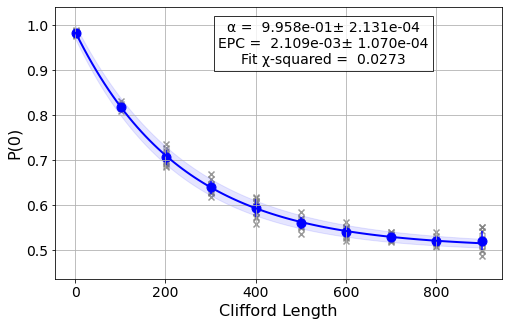

In [42]:
lengths = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010
qubits = [0]
# Run an RB experiment on qubit 0
exp1 = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)
expdata1 = exp1.run(backend)
expdata1.block_for_results()
result = expdata1.analysis_results(0)
# View result data
print(result)
display(expdata1.figure(0))

## Running 2-qubit RB experiment

Running a 1-qubit RB experiment and a 2-qubit RB experiment, in order to calculate the gate error (EPG) of  the `cx` gate:


Analysis Result: StandardRB
Analysis Result ID: c458cbc5-8f70-4c93-a416-5a82dc345f6e
Experiment ID: b70311b0-ea64-4af3-b1d2-ab0b95ff79dc
Device Components: [<Qubit(Q1)>, <Qubit(Q4)>]
Quality: None
Verified: False
Result Data:<super: <class 'CurveAnalysisResultData'>, <CurveAnalysisResultData object>>
  - a: 0.6929359057250185 ± 0.022809600699452162
  - alpha: 0.9544996812764374 ± 0.003341829326697232
  - b: 0.2647774987044865 ± 0.006159040209452071


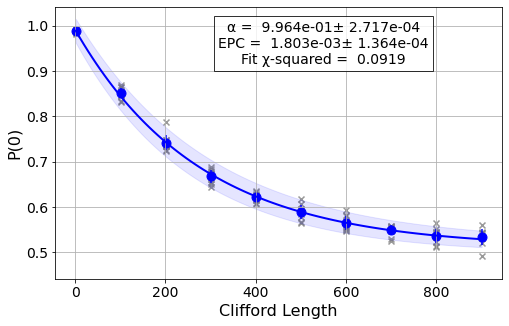

Backend's reported EPG of the cx gate: 0.012438847900902494
Experiment computed EPG of the cx gate: 0.01262803065926493


In [44]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = (1,4)

# Run a 1-qubit RB expriment on qubits 1, 4 to determine the error-per-gate of 1-qubit gates
epg_data = {}
lengths_1_qubit = np.arange(1, 1000, 100)
for qubit in qubits:
    exp = StandardRB([qubit], lengths_1_qubit, num_samples=num_samples, seed=seed)
    expdata = exp.run(backend)
    expdata.block_for_results()
    epg_data[qubit] = expdata.analysis_results(0).data()['EPG'][qubit]
    
# Run an RB experiment on qubits 1, 4
exp2 = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)

# Use the EPG data of the 1-qubit runs to ensure correct 2-qubit EPG computation
exp2.set_analysis_options(epg_1_qubit=epg_data)

# Run the 2-qubit experiment
expdata2 = exp2.run(backend)
expdata2.block_for_results()
# View result data
result = expdata2.analysis_results(0)
# View result data
print(result)
display(expdata2.figure(0))

# Compare the computed EPG of the cx gate with the backend's recorded cx gate error:
expected_epg = RBUtils.get_error_dict_from_backend(backend, qubits)[(qubits, 'cx')]
expdata2.block_for_results()
exp2_epg = expdata2.analysis_results(0).data()['EPG'][qubits]['cx']
print("Backend's reported EPG of the cx gate:", expected_epg)
print("Experiment computed EPG of the cx gate:", exp2_epg)

## Displaying the RB circuits

Generating an example RB circuit:

In [45]:
# Run an RB experiment on qubit 0
exp = StandardRB(qubits=[0], lengths=[10], num_samples=1, seed=seed)
c = exp.circuits()[0]

We transpile the circuit into the backend's basis gate set:

global phase: π/2
         ░ ┌──────────┐┌────┐┌───────┐ ░ ┌────┐┌─────────┐ ░ ┌──────────┐┌────┐»
   q_0: ─░─┤ RZ(3π/2) ├┤ √X ├┤ RZ(π) ├─░─┤ √X ├┤ RZ(π/2) ├─░─┤ RZ(3π/2) ├┤ √X ├»
         ░ └──────────┘└────┘└───────┘ ░ └────┘└─────────┘ ░ └──────────┘└────┘»
meas: 1/═══════════════════════════════════════════════════════════════════════»
                                                                               »
«        ┌───────┐ ░ ┌────┐┌────┐┌───────┐ ░  ░ ┌─────────┐┌────┐ ░ ┌────┐»
«   q_0: ┤ RZ(π) ├─░─┤ √X ├┤ √X ├┤ RZ(π) ├─░──░─┤ RZ(π/2) ├┤ √X ├─░─┤ √X ├»
«        └───────┘ ░ └────┘└────┘└───────┘ ░  ░ └─────────┘└────┘ ░ └────┘»
«meas: 1/═════════════════════════════════════════════════════════════════»
«                                                                         »
«        ┌─────────┐ ░ ┌──────────┐ ░ ┌────┐┌──────────┐ ░ ┌────┐┌──────────┐»
«   q_0: ┤ RZ(π/2) ├─░─┤ RZ(3π/2) ├─░─┤ √X ├┤ RZ(3π/2) ├─░─┤ √X ├┤ RZ(3π/2) ├»
«        └─────────┘ ░ └──────────┘ ░ └

# 2. Interleaved RB experiment

Interleaved RB experiment is used to estimate the gate error of the interleaved gate (see Ref. [4]).

In addition to the usual RB parameters, we also need to provide:

- `interleaved_element`: the element to interleave, given either as a group element or as an instruction/circuit

The output of the RB Experiment includes the following:

- `EPC`: The estimated error of the interleaved gate.

- `EPC_err`: The statistical error bounds of the interleaved gate error.

- `alpha` and `alpha_c`: The depolarizing parameters of the original and interleaved RB sequences respectively.

- `EPC_systematic_err`: The systematic error of the interleaved gate error (see Ref. [4]).

- `EPC_systematic_bounds`: The systematic error bounds of the interleaved gate error (see Ref. [4]).


## Running 1-qubit interleaved RB experiment


Analysis Result: InterleavedRB
Analysis Result ID: 09fe7f5e-9e9b-467b-8e33-96aff91edae4
Experiment ID: 716943ea-2bd8-4c08-ae4c-a5145feae05b
Device Components: [<Qubit(Q0)>]
Quality: None
Verified: False
Result Data:<super: <class 'CurveAnalysisResultData'>, <CurveAnalysisResultData object>>
  - a: 0.47232732531191335 ± 0.00486545513809845
  - alpha: 0.9922736206619418 ± 0.00046530977258629665
  - alpha_c: 0.9992000301101287 ± 0.0006795663174965497
  - b: 0.5131165018945552 ± 0.004130698176674867


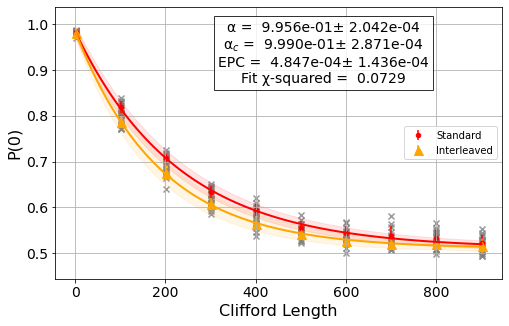

In [53]:
lengths = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010
qubits = [0]

# Run an Interleaved RB experiment on qubit 0
# The interleaved gate is the x gate
int_exp1 = InterleavedRB(
    circuits.XGate(), qubits, lengths, num_samples=num_samples, seed=seed)
int_expdata1 = int_exp1.run(backend)
int_expdata1.block_for_results()
result = int_expdata1.analysis_results(0)
# View result data
print(result)
display(int_expdata1.figure(0))

## Running 2-qubit interleaved RB experiment


Analysis Result: InterleavedRB
Analysis Result ID: d8f8829b-1aa8-4634-aaf8-674b0a21a93e
Experiment ID: a5c8ef1a-e968-44cb-a1c0-ed0b77013478
Device Components: [<Qubit(Q4)>, <Qubit(Q6)>]
Quality: None
Verified: False
Result Data:<super: <class 'CurveAnalysisResultData'>, <CurveAnalysisResultData object>>
  - a: 0.6841473058243658 ± 0.011881437370152707
  - alpha: 0.9647228193210475 ± 0.002898650183126707
  - alpha_c: 0.9828684270708686 ± 0.006186385384431984
  - b: 0.25831597065442236 ± 0.0054340644025495715


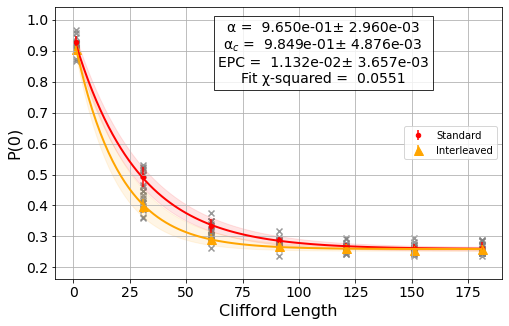

In [54]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [4,6]

# Run an Interleaved RB experiment on qubits 4, 6
# The interleaved gate is the cx gate
int_exp2 = InterleavedRB(
    circuits.CXGate(), qubits, lengths, num_samples=num_samples, seed=seed)
int_expdata2 = int_exp2.run(backend)
int_expdata2.block_for_results()
result = int_expdata2.analysis_results(0)
# View result data
print(result)
display(int_expdata2.figure(0))

# 3. Simultaneous RB experiment

We use `ParallelExperiment` to run the RB experiment simultaneously on different qubits (see Ref. [5])

In [55]:
lengths = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010
qubits = range(5)

# Run a parallel 1-qubit RB experiment on qubits 0, 1, 2, 3, 4
exps = [StandardRB([i], lengths, num_samples=num_samples, seed=seed + i)
        for i in qubits]

par_exp = ParallelExperiment(exps)
par_expdata = par_exp.run(backend)
par_expdata.block_for_results()
result = par_expdata.analysis_results(0)
# View result data
print(result)


Analysis Result: ParallelExperiment
Analysis Result ID: 3062eb76-1c37-4c05-818f-d319805a0b2d
Experiment ID: 87453808-f461-4ba9-8b15-7353687b369b
Device Components: [<Qubit(Q0)>, <Qubit(Q1)>, <Qubit(Q2)>, <Qubit(Q3)>, <Qubit(Q4)>]
Quality: None
Verified: False
Result Data:
- experiment_types: ['StandardRB', 'StandardRB', 'StandardRB', 'StandardRB', 'StandardRB']
- experiment_ids: ['fbb4037f-ec1a-402c-a18b-67c29a8b9cb2', '82d8af54-6de3-4bc1-9320-b858fb08b01b', 'c5ac2776-3032-4b09-92c8-417cc45615d2', 'db14b873-de8e-4bd9-8510-8eec88d01bd0', '9a8fd04e-4bd7-429d-9a9a-875f0aa03450']
- experiment_qubits: [(0,), (1,), (2,), (3,), (4,)]
- success: True


## Viewing sub experiment data

The experiment data returned from a batched experiment also contains individual experiment data for each sub experiment which can be accessed using `experiment_data(index)`


Analysis Result: StandardRB
Analysis Result ID: 4af73908-7c28-4d3f-93f9-277cbf06a5a8
Experiment ID: fbb4037f-ec1a-402c-a18b-67c29a8b9cb2
Device Components: [<Qubit(Q0)>]
Quality: None
Verified: False
Result Data:<super: <class 'CurveAnalysisResultData'>, <CurveAnalysisResultData object>>
  - a: 0.472423854983935 ± 0.007323434270652189
  - alpha: 0.992415395433248 ± 0.0004963496696526609
  - b: 0.513005271479229 ± 0.0059210051055150125 



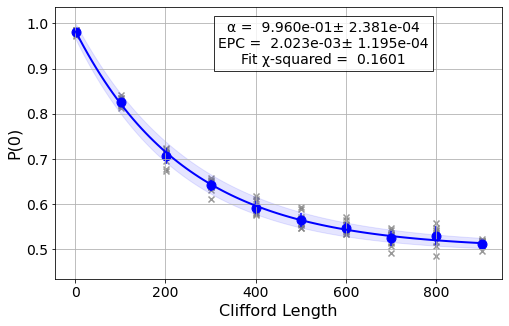


Analysis Result: StandardRB
Analysis Result ID: afc31923-7943-49ba-8803-d48d77a2b199
Experiment ID: 82d8af54-6de3-4bc1-9320-b858fb08b01b
Device Components: [<Qubit(Q1)>]
Quality: None
Verified: False
Result Data:<super: <class 'CurveAnalysisResultData'>, <CurveAnalysisResultData object>>
  - a: 0.4854637242163364 ± 0.008097838491285765
  - alpha: 0.9940827216204067 ± 0.0004396045872301562
  - b: 0.5063601554912435 ± 0.007567781960877947 



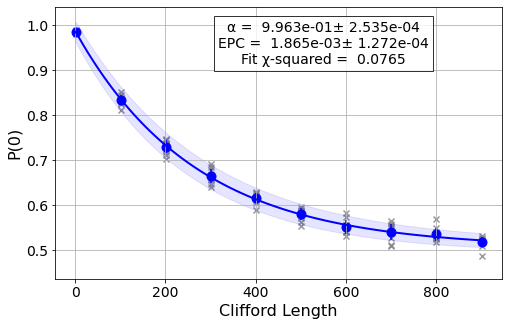


Analysis Result: StandardRB
Analysis Result ID: 45123d07-f06b-41c0-93e5-87eafcbdb8c1
Experiment ID: c5ac2776-3032-4b09-92c8-417cc45615d2
Device Components: [<Qubit(Q2)>]
Quality: None
Verified: False
Result Data:<super: <class 'CurveAnalysisResultData'>, <CurveAnalysisResultData object>>
  - a: 0.4778421965902396 ± 0.008069267430297837
  - alpha: 0.9938466447480387 ± 0.0003879400483220432
  - b: 0.5089464493173589 ± 0.007850476894235682 



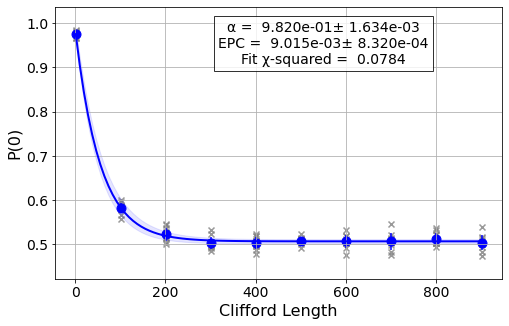


Analysis Result: StandardRB
Analysis Result ID: 43412b18-9d41-41d3-8f4c-32dde9a036b4
Experiment ID: db14b873-de8e-4bd9-8510-8eec88d01bd0
Device Components: [<Qubit(Q3)>]
Quality: None
Verified: False
Result Data:<super: <class 'CurveAnalysisResultData'>, <CurveAnalysisResultData object>>
  - a: 0.4744639297038514 ± 0.009005935103403712
  - alpha: 0.9689728729834152 ± 0.008540967325550436
  - b: 0.5084226371965305 ± 0.004239931469677474 



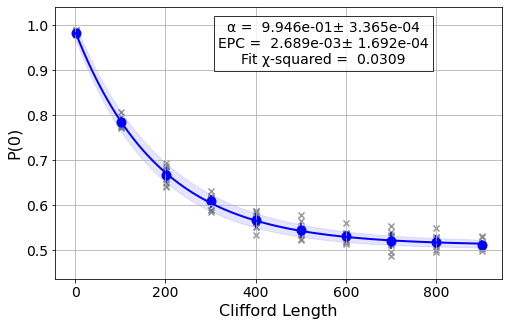


Analysis Result: StandardRB
Analysis Result ID: f2cfff85-b160-4e8d-b673-b1dce9beefa3
Experiment ID: 9a8fd04e-4bd7-429d-9a9a-875f0aa03450
Device Components: [<Qubit(Q4)>]
Quality: None
Verified: False
Result Data:<super: <class 'CurveAnalysisResultData'>, <CurveAnalysisResultData object>>
  - a: 0.4766401170118983 ± 0.008031932246357627
  - alpha: 0.9906733893649763 ± 0.0005937391217694649
  - b: 0.5106142253430586 ± 0.005630094683732987 



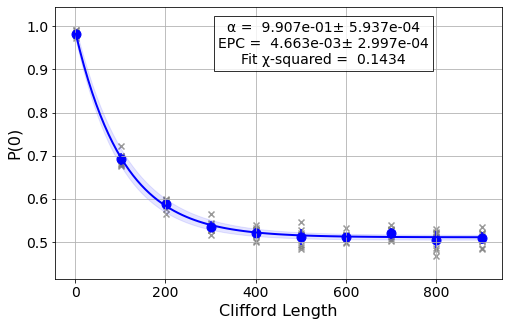

In [56]:
# Print sub-experiment data
for i in range(par_exp.num_experiments):
    print(par_expdata.component_experiment_data(i).analysis_results(0), '\n')
    display(par_expdata.component_experiment_data(i).figure(0))

## References

[1] Easwar Magesan, J. M. Gambetta, and Joseph Emerson, *Robust randomized benchmarking of quantum processes*, https://arxiv.org/pdf/1009.3639

[2] Easwar Magesan, Jay M. Gambetta, and Joseph Emerson, *Characterizing Quantum Gates via Randomized Benchmarking*, https://arxiv.org/pdf/1109.6887

[3] David C. McKay, Sarah Sheldon, John A. Smolin, Jerry M. Chow, and Jay M. Gambetta, *Three Qubit Randomized Benchmarking*, https://arxiv.org/pdf/1712.06550

[4] Easwar Magesan, Jay M. Gambetta, B. R. Johnson, Colm A. Ryan, Jerry M. Chow, Seth T. Merkel, Marcus P. da Silva, George A. Keefe, Mary B. Rothwell, Thomas A. Ohki, Mark B. Ketchen, M. Steffen, 
*Efficient measurement of quantum gate error by interleaved randomized benchmarking*,
https://arxiv.org/pdf/1203.4550

[5] Jay M. Gambetta, A. D. C´orcoles, S. T. Merkel, B. R. Johnson, John A. Smolin, Jerry M. Chow, Colm A. Ryan, Chad Rigetti, S. Poletto, Thomas A. Ohki, Mark B. Ketchen, and M. Steffen, *Characterization of addressability by simultaneous randomized benchmarking*, https://arxiv.org/pdf/1204.6308

